In [21]:
import numpy as np #all imports
import matplotlib
import math
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure 
from itertools import combinations,permutations

In [22]:
#binder link:
#https://mybinder.org/v2/gh/ahumpage1/RA-assign/master

In [23]:
#load in the positions of the antenna for the VLA D configuration
x,y,z,r=np.loadtxt("/home/jovyan/ant_pos.txt",unpack=True)
#define some quantities to be used later
c=3e8
freq=5
wave=(c/(freq*1e9))
#wavelength=c/frequency

In [24]:
#a plotting function, to make the code cleaner
def plotter(x,xaxis,yaxis,title,y=0,colour="c",scatter=1,imshow=0,plot=0):
    if scatter==1:
        figure(figsize=(8,8))
        plt.scatter(x,y,color=colour,s=1)
        plt.title(title)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.grid()
        plt.show()
    elif imshow==1:
        figure(figsize=(8,8))    
        plt.imshow(x,cmap=colour,origin="lower")
        plt.title(title)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.show()
    elif plot==1:
        plt.plot(x,colour,markersize=1)
        plt.title(title)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)        
        plt.show()
    return

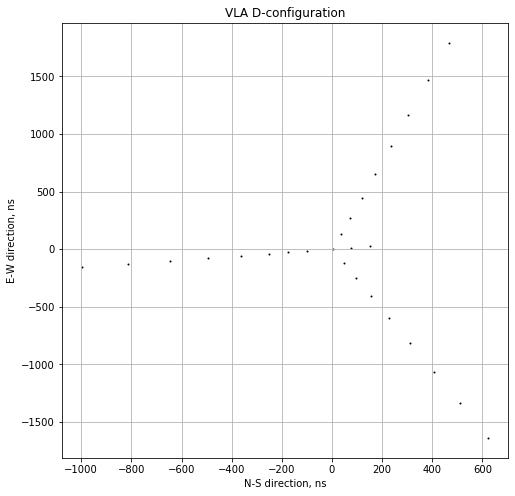

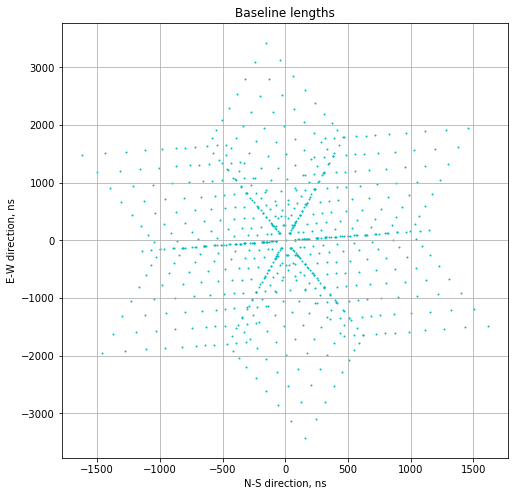

In [25]:
#a plot of the positions
plotter(x,"N-S direction, ns","E-W direction, ns","VLA D-configuration",y=y,colour="k")

#find different permutations of the telescopes, so that the baselines can all be calculated
for a, b in permutations(x, 2):
    x=np.append(x,a-b)
for a, b in permutations(y, 2):
    y=np.append(y,a-b)
for a, b in permutations(z, 2):
    z=np.append(z,a-b)
#baseline calculations and plot
hyp=np.sqrt(x**2 + y**2 + z**2)
long=c*np.max(hyp/1e9) #longest baseline
plotter(x,"N-S direction, ns","E-W direction, ns","Baseline lengths",y=y)

#matrix of the positions
xyz=np.matrix([x,y,z])

In [26]:
#function to find the uv plane.
#equation used is a matrix multiplication:
#s is sin, cos is cos, H is hourangle, d is declination
def uvplt(vec,H):
    uv=np.zeros((2,1))
    figure(figsize=(8,8))
    for Hangle in np.arange(-0.5,0.5,(1/120)): #loop for each hour angle change
        dec=np.radians(H)
        sH=np.sin(Hangle)
        cH=np.cos(Hangle)
        sd=np.sin(dec)
        cd=np.cos(dec)
        #matrix which determines the change in positions
        uvmat=np.matrix([[sH,cH,0],[-sd*cH,sd*sH,cd],[cd*cH,-cd*sH,sd]])
        #times matrices together to get uv, and plot
        uvw=uvmat*vec
        plt.scatter([uvw[0]],[uvw[1]],s=1,color='c')
        #add uv to array of all
        uv=np.append(uv,uvw[0:2],axis=1)
    uv=np.delete(uv,0,axis=1)
    plt.title("UV coverage over 1 hour")
    plt.xlabel("N-S direction,ns")
    plt.ylabel("E-W direction,ns")
    plt.grid()
    plt.show()
    #fourier transform to get dirty beam and plot of beam
    synth=np.fft.fft2(uv)
    plotter(np.real(synth[0]),"","","FFT of UV coverage",y=np.real(synth[1]))
    return uv,synth

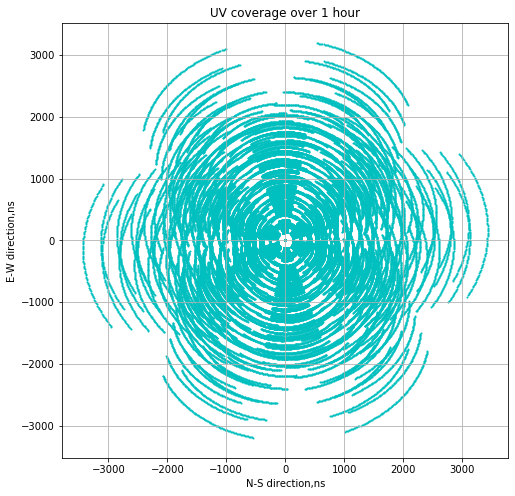

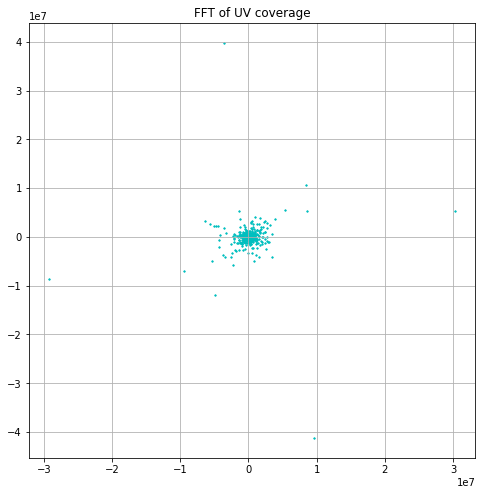

In [27]:
#find the uv plane, with thearray pointing directly at the source in the centre
uv,synth=uvplt(xyz,45)

In [28]:
#make array for size and positions of the map of the sky, and the sources
FOV=(60*45)/freq 
#field of view= 45/v(Ghz) in arcminutes
pixnum=256
pixsize=FOV/pixnum 
#size of a pixel
mp=np.zeros([pixnum,pixnum])
mid=int((pixnum+2)/2)
#mid point of field, to make into centre source
mp[mid,mid]=3.6
ras2=int(10/pixsize)
decs2=int((3*60)/pixsize)
s2r=mid+ras2+1
s2d=mid+decs2+1
mp[s2r,s2d]=5.8

FWHM of the primary beam: 10.368 arcseconds


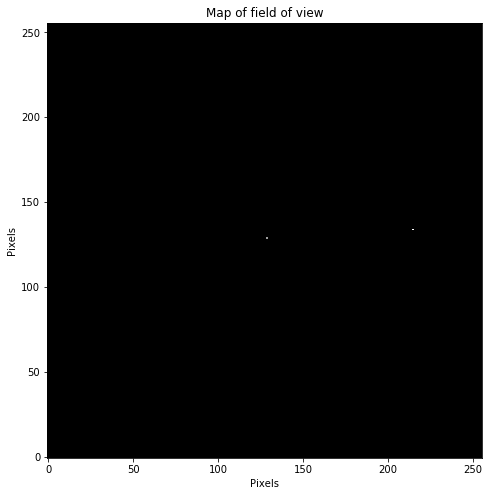

FWHM of the primary beam: 10.368 arcseconds


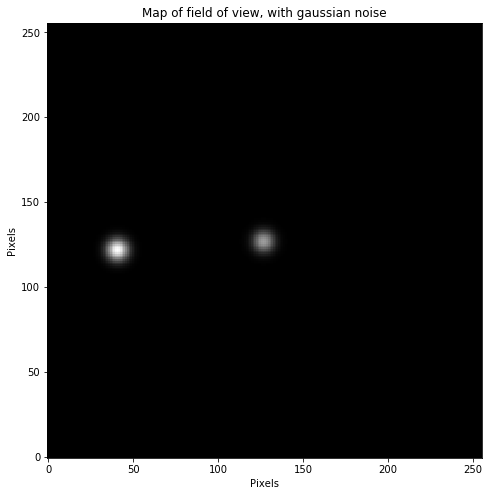

In [29]:
#calculations to get a gaussian noise on the sources

FWHM=3600*(1.2*(wave))/25 #FWHM of the primary beam
print("FWHM of the primary beam:",FWHM,"arcseconds")
sig=FWHM/2.35 #sigma of primary beam
y1=np.arange(s2r-pixnum,s2r,1)
x1=np.arange(s2d-pixnum,s2d,1)
xx,yy=np.meshgrid(x1,y1)
z=np.hypot(xx,yy)
gauss=np.exp(-np.power((z-0),2)/(2*np.power(sig, 2)))
I1=5.8*gauss

x2=np.arange(mid-pixnum,mid,1)
y2=np.arange(mid-pixnum,mid,1) 
xx2,yy2=np.meshgrid(x2,y2)
z2=np.hypot(xx2,yy2)
gauss=np.exp(-np.power((z2-0),2)/(2*np.power(sig,2)))
I2=3.6*gauss

#add gaussian of each source and plot both the point source map and gaussian map
I=I1+I2
plotter(mp,"Pixels","Pixels","Map of field of view",scatter=0,imshow=1,colour="gray")
print("FWHM of the primary beam:",FWHM,"arcseconds")
plotter(I,"Pixels","Pixels","Map of field of view, with gaussian noise",scatter=0,imshow=1,colour="gray")

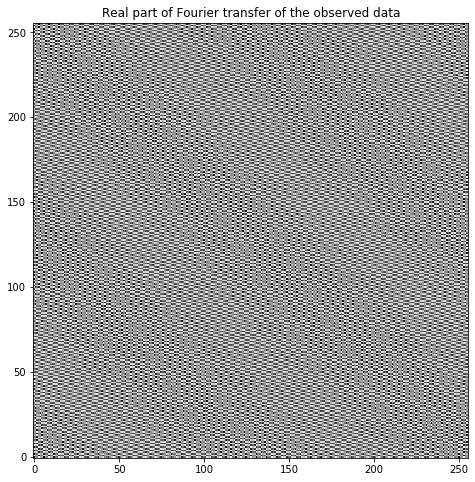

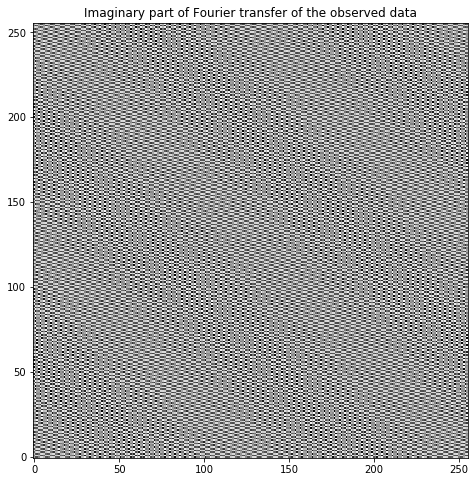

In [30]:
#fourier transform of the map, with the real and imaginary parts plotted seperately
ft=np.fft.fft2(mp)
plotter(np.real(ft),"","","Real part of Fourier transfer of the observed data",scatter=0,imshow=1,colour="Greys")
plotter(np.imag(ft),"","","Imaginary part of Fourier transfer of the observed data",scatter=0,imshow=1,colour="Greys")

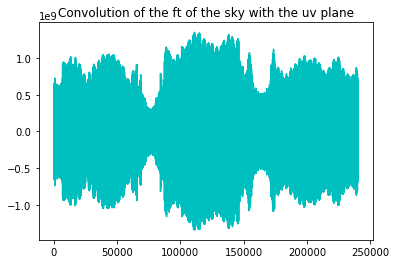

In [31]:
#convolution of the ft uv plane and the map, then plotted. This is the signal from the infeterometer
resp=np.convolve(np.ravel(synth),np.ravel(ft))
plotter(np.real(resp),"","","Convolution of the ft of the sky with the uv plane",scatter=0,plot=1)

In [32]:
#I do not think that the units are correct and I don't know how to find the actual dimensions of the beams
#An envelope pattern can be seen in the convolution
#as well as two main nodes. These could be from the two sources

In [33]:
print("References:")
print("Grainge, K. and Scaife, A. (2019). PHYS64591 Radio Astronomy.")
print("Jackson, N. (2019). PHYS60441 Radio Interferometry. Lecture notes available at http://www.jb.man.ac.uk/~njj/p60441_interferometry.pdf")
print("Thompson, A., Moran, J. and Swenson Jr, G. (2017). Interferometry and Synthesis in Radio Astronomy. Cham:Springer International Publishing")
print("Telescope positions from the VLA website - Science.nrao. (2019). An Overview of the VLA. [online] Available at: https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview [Accessed 28 Nov. 2019].")
print("Field of view calculation from the VLA website - Science.nrao.edu. (2019). Field of View — Science Website. [online] Available at: https://science.nrao.edu/facilities/vla/docs/manuals/oss2014A/performance/fov/referencemanual-all-pages [Accessed 28 Nov. 2019].")
print("Primary beam calculation: Isella, A. (2012). CASA Radio Analysis Workshop. [online] Science.nrao.edu. Available at: https://science.nrao.edu/opportunities/courses/casa-caltech-winter2012/Isella_Radio_Interferometry_Basics_Caltech2012.pdf [Accessed 28 Nov. 2019].")

References:
Grainge, K. and Scaife, A. (2019). PHYS64591 Radio Astronomy.
Jackson, N. (2019). PHYS60441 Radio Interferometry. Lecture notes available at http://www.jb.man.ac.uk/~njj/p60441_interferometry.pdf
Thompson, A., Moran, J. and Swenson Jr, G. (2017). Interferometry and Synthesis in Radio Astronomy. Cham:Springer International Publishing
Telescope positions from the VLA website - Science.nrao. (2019). An Overview of the VLA. [online] Available at: https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview [Accessed 28 Nov. 2019].
Field of view calculation from the VLA website - Science.nrao.edu. (2019). Field of View — Science Website. [online] Available at: https://science.nrao.edu/facilities/vla/docs/manuals/oss2014A/performance/fov/referencemanual-all-pages [Accessed 28 Nov. 2019].
Primary beam calculation: Isella, A. (2012). CASA Radio Analysis Workshop. [online] Science.nrao.edu. Available at: https://science.nrao.edu/opportunities/courses/casa-caltech-win